# 무작정 따라하는 강화학습

## 1. 모듈 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym
from typing import Dict, NamedTuple, List
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import os

## 2. OpenAI의 gym 환경 불러오기

In [2]:
# gym 환경 불러오기
env = gym.make('CartPole-v0')

# cuda가 설치되어 있다면 cuda를 사용하고 아니라면 cpu만을 사용한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 3. Experience 클래스 정의하기

#### Deep Q-learning 알고리즘의 *Transition* 을 만들기 위해서는 다음과 같은 정보가 필요하다.

논문의 용어를 가져오면 다음과 같다.

1. obs: $s_t$
2. action: $a_t$
3. reward: $r_t$
4. done: $t = T$이면 True이고, $t \not= T$이면 False
5. next_obs: $s_{t+1}$

In [3]:
class Experience(NamedTuple):
    obs: np.ndarray
    action: np.ndarray
    reward: float
    done: bool
    next_obs: np.ndarray

# 하나의 에피소드에서 모든 Experience를 저장한다.
Trajectory = List[Experience]

# Trajectory에서 일정한 크기의 Experience를 임의로 뽑아낸다.
Buffer = List[Experience]

## 4. model 클래스 정의하기

In [4]:
# PyTorch를 사용해서 다음과 같은 뉴럴 네트워크 구조를 만든다.
class model(nn.Module):
    def __init__(self, input_size, output_size):
        super(model, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

## 5. 학습자 클래스 정의하기

저번 챕터의 *Q-learning* 알고리즘에서 설명한 $Q(S, A)$를 업데이트 방법에 주목하자.

$ Q(S,A) \leftarrow Q(S,A) + \alpha\left[ R + \gamma \underset{a}{\mathrm{max}} Q(S', a) - Q(S,A) \right]$

이 수식을 학습자 클래스의 **update_q_net**에서 코드로 볼 수 있다.


In [5]:
class Trainer:
    
    # generate_trajectory는 학습 전에 쓰이는 데이터를 수집한다.
    @staticmethod
    def generate_trajectory(
        q_net: model, buffer_size: int, epsilon: float
    ):
        # 이는 Replay Memory를 사용하기 위한 버퍼이다.
        buffer: Buffer = []
        
        # 환경으로부터 초기 상태 값을 가져온다.
        observation = env.reset()
        
        # 에이전트의 Transition을 저장한다.
        trajectory_from_agent: [Trajectory] = []
            
        # 환경의 전 상태값을 저장한다.
        last_obs_from_agent = np.ndarray
        
        # Return을 계산하기 위해 축적된 보상을 저장한다.
        cumulative_reward_from_agent = 0
        
        # Return들을 저장한다.
        cumulative_rewards: List[float] = []
            
            
        # 설정의 버퍼의 크기 만큼만 버퍼에 Transition을 저장한다.
        while len(buffer) < buffer_size:
            #=============================================
            # 엡실론 greedy 방법으로 행동을 선택한다.
            #=============================================
            if not len(buffer) == 0: # not first step:
                action_values = (
                    q_net(torch.from_numpy(observation)).detach().numpy()
                )
                
                if random.uniform(0, 1) <= epsilon:
                    action_ind = env.action_space.sample()
                else:
                    action_ind = np.argmax(action_values)
            else:
                action_ind = env.action_space.sample()
                
            action = [action_ind]
            #=============================================
            
            # 에이전트가 한번의 step을 진행한다.
            next_observation, reward, done, _ = env.step(action_ind)
            
            
            # 만약 Terminal 상태에 도달하지 않았다면 다음 코드를 실행한다.
            if not done:
                exp = Experience(
                    obs = observation,
                    reward = reward,
                    done = False,
                    action = action,
                    next_obs = next_observation
                )
                trajectory_from_agent.append(exp)
                cumulative_reward_from_agent += reward
                observation = next_observation
                
            # 만약 Terminal 상태에 도달했다면 다음 코드를 실행한다.
            else:
                last_experience = Experience(
                    obs = observation,
                    reward = reward,
                    done = done,
                    action = action,
                    next_obs = next_observation
                )
                
                cumulative_reward = cumulative_reward_from_agent + reward
                cumulative_rewards.append(cumulative_reward)
                cumulative_reward_from_agent = 0
                
                buffer.extend(trajectory_from_agent)
                buffer.append(last_experience)
                
                # 하나의 Trajectory가 수집되었으므로 환경을 초기화하고 다시 반복한다.
                env.reset()
            
        # 얻어진 데이터와 보상 축적값의 평균값을 리턴한다.
        return buffer, np.mean(cumulative_rewards)
    
    # update_q_net은 뉴럴 네트워크에 대하여 Gradient Descent를 진행한다.
    @staticmethod
    def update_q_net(
        q_net: model,
        optimizer: torch.optim,
        buffer: Buffer,
        action_size = int
    ):
        BATCH_SIZE = 1000
        NUM_EPOCH = 3
        GAMMA = 0.9
        batch_size = min(len(buffer), BATCH_SIZE)
        random.shuffle(buffer)

        # 버퍼에서 배치의 크기만큼 데이터를 추출한다.
        batches = [
            buffer[batch_size * start : batch_size * (start + 1)]
            for start in range(int(len(buffer) / batch_size))
        ]

        for _ in range(NUM_EPOCH):
            for batch in batches:
                obs = torch.from_numpy(np.stack([ex.obs for ex in batch]))
                reward = torch.from_numpy(
                    np.array([ex.reward for ex in batch], dtype = np.float32).reshape(-1, 1)
                )
                done = torch.from_numpy(
                    np.array([ex.done for ex in batch], dtype = np.float32).reshape(-1, 1)
                )
                action = torch.from_numpy(np.stack([ex.action for ex in batch])).to(torch.int64)
                next_obs = torch.from_numpy(np.stack([ex.next_obs for ex in batch]))
        
                # 전 챕터에서 설명한 Deep Q-learning의 타겟이다.
                target = (
                    reward
                    + (1.0 - done)
                    * GAMMA
                    * torch.max(q_net(next_obs).detach(), dim=1, keepdim=True).values
                )

                #=============================================
                # 뉴럴 네트워크의 에러를 구한다.
                #=============================================
                mask = torch.zeros((len(batch), action_size))
                mask.scatter_(1, action, 1)
                
                prediction = torch.sum(q_net(obs) * mask, dim = 1, keepdim = True)
                criterion = nn.MSELoss()
                loss = criterion(prediction, target)
                #=============================================

                
                #=============================================
                # Gradient Descent
                #=============================================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                #=============================================

## 6. 에이전트 학습시키기

Training step: 1	reward: 9.408163265306122
Training step: 2	reward: 9.553191489361701
Training step: 3	reward: 11.488372093023257
Training step: 4	reward: 14.837837837837839
Training step: 5	reward: 11.833333333333334
Training step: 6	reward: 14.384615384615385
Training step: 7	reward: 169.0
Training step: 8	reward: 28.571428571428573
Training step: 9	reward: 184.0909090909091
Training step: 10	reward: 67.11764705882354
Training step: 11	reward: 58.8421052631579
Training step: 12	reward: 19.575757575757574
Training step: 13	reward: 47.9
Training step: 14	reward: 130.92307692307693
Training step: 15	reward: 93.6
Training step: 16	reward: 184.27272727272728
Training step: 17	reward: 183.0909090909091
Training step: 18	reward: 149.33333333333334
Training step: 19	reward: 47.76190476190476
Training step: 20	reward: 9.829787234042554
Training step: 21	reward: 112.35714285714286
Training step: 22	reward: 10.866666666666667
Training step: 23	reward: 14.736842105263158
Training step: 24	reward

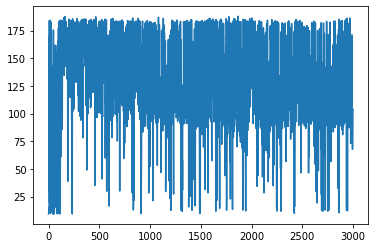

In [6]:
#=============================================
# 만약 환경이 실행중이라면 종료
#=============================================
try:
    env.close()
except:
    pass
#=============================================

#=============================================
# 학습에 필요한 값들을 초기화한다.
#=============================================
env.reset()

num_actions = env.action_space.n
num_obs = env.observation_space.shape[0]

# 아래 3개의 변수는 엡실론 스케쥴링을 위해 필요하다.
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
#=============================================

try:
    qnet = model(num_obs, num_actions)
    
    experiences: Buffer = []
    optim = torch.optim.Adam(qnet.parameters(), lr = 0.001)
    
    cumulative_rewards: List[float] = []
    
    NUM_TRAINING_STEPS = int(os.getenv('QLEARNING_NUM_TRAINING_STEPS', 3000))
    NUM_NEW_EXP = int(os.getenv("QLEARNING_NUM_NEW_EXP", 10000))
    BUFFER_SIZE = int(os.getenv("QLEARNING_BUFFER_SIZE", 1000))
    
    for n in range(NUM_TRAINING_STEPS):
        
        # 엡실론을 설정한다.
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * n /EPS_DECAY)
        
        # 학습에 사용될 데이터를 가져온다.
        new_exp, _ = Trainer.generate_trajectory(qnet, NUM_NEW_EXP, epsilon = eps_threshold)
        
        # 전 챕터에서 언급한 데이터의 독립성을 보장하기 위해 필요하다.
        random.shuffle(experiences)
        
        # 버퍼 사이즈 만큼만 데이터를 수집한다.
        if len(experiences) > BUFFER_SIZE:
            experiences = experiences[:BUFFER_SIZE]
        experiences.extend(new_exp)
        
        # 학습을 진행하고 보상값을 저장 및 출력한다.
        Trainer.update_q_net(qnet, optim, experiences, num_actions)
        _, rewards = Trainer.generate_trajectory(qnet, 10000, epsilon = 0)
        cumulative_rewards.append(rewards)
        print(f"Training step: {n+1}\treward: {rewards}")
except KeyboardInterrupt:
    print("\nTraining interrupted")
finally:
    env.close()

# 학습이 끝나면 보상의 변화를 그래프로 표현하고 모델을 저장한다.
try:
    plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards)
    
    # SAVE MODEL
    torch.save(qnet, './saved_models/model.pt')
    
except ValueError:
    print("\nPlot failed on interrupted training.")